In [1]:
!pip install numpy pandas reedsolo faker tensorflow scikit-learn matplotlib sqlalchemy

In [2]:
import numpy as np
import pandas as pd
import struct
import matplotlib.pyplot as plt
from reedsolo import RSCodec
from faker import Faker
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sqlalchemy import create_engine

# Set random seed for reproducibility
np.random.seed(42)

In [3]:
fake = Faker()

def generate_satellite_data(num_samples=10000):
    data = []
    for _ in range(num_samples):
        data.append({
            'timestamp': fake.date_time_this_decade(),
            'satellite_id': fake.random_element(elements=('SAT-01', 'SAT-02', 'SAT-03')),
            'sensor_reading': np.random.uniform(0, 100),
            'temperature': np.random.uniform(-50, 50),
            'radiation_level': np.random.uniform(0, 1000),
            'status_code': fake.random_int(min=100, max=599),
            'data': fake.binary(length=16)
        })
    return pd.DataFrame(data)

original_df = generate_satellite_data(10000)
print("✅ Dataset generated with shape:", original_df.shape)

✅ Dataset generated with shape: (10000, 7)


In [4]:
rs = RSCodec(10)  # Can correct up to 5 errors

def float_to_bytes(value):
    return struct.pack('f', value)

def bytes_to_float(byte_data):
    return struct.unpack('f', byte_data)[0]

def process_value(value, error_prob=0.1, num_errors=3):
    try:
        byte_data = float_to_bytes(value)
        encoded = rs.encode(byte_data)
        
        corrupted = bytearray(encoded)
        for _ in range(num_errors):
            if np.random.random() < error_prob:
                pos = np.random.randint(0, len(corrupted))
                corrupted[pos] ^= 0xff
        
        decoded = rs.decode(corrupted)[0]
        return bytes_to_float(decoded), bytes_to_float(corrupted[:4])
    except:
        return value, value

# Apply to sensor readings and temperature
corrupted_features = []
for col in ['sensor_reading', 'temperature']:
    rs_corrected = []
    corrupted = []
    for value in original_df[col]:
        corrected, corrupt = process_value(value)
        rs_corrected.append(corrected)
        corrupted.append(corrupt)
    
    original_df[f'{col}_corrupted'] = corrupted
    original_df[f'{col}_rs_corrected'] = rs_corrected
    corrupted_features.append(f'{col}_corrupted')

print("✅ Errors introduced and Reed-Solomon applied")

✅ Errors introduced and Reed-Solomon applied


In [5]:
X = original_df[corrupted_features]
y = original_df[['sensor_reading', 'temperature']]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

print(f"Training data shape: {X_train.shape}, Test data shape: {X_test.shape}")

Training data shape: (8000, 2), Test data shape: (2000, 2)


In [6]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(2,)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(2)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

print("✅ Model training completed")

C:\Users\koust\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 353.0871 - mae: 10.3058 - val_loss: 75.5994 - val_mae: 2.8667
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 63.9334 - mae: 2.6647 - val_loss: 77.3203 - val_mae: 3.6278
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 71.4282 - mae: 3.2544 - val_loss: 74.6889 - val_mae: 3.0706
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 76.0841 - mae: 3.3732 - val_loss: 71.6127 - val_mae: 2.8327
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 62.9974 - mae: 2.8013 - val_loss: 70.8851 - val_mae: 3.4056
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 59.6122 - mae: 2.8242 - val_loss: 70.8062 - val_mae: 3.6392
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 63.8265 - mae: 3.0810 - val_loss: 68.7473 - val_mae: 3.2632
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 64.1831 - mae: 2.9927 - val_loss: 73.0026 - val_mae: 3.8734
Epoch 9/50
200/200 ━━━━━━━━━━━━━━━━━━━

In [7]:
y_pred = model.predict(X_test)

rs_pred = X_test.join(original_df[['sensor_reading_rs_corrected', 'temperature_rs_corrected']])

model_mse = mean_squared_error(y_test, y_pred)
model_mae = mean_absolute_error(y_test, y_pred)

rs_mse = mean_squared_error(
    y_test,
    rs_pred[['sensor_reading_rs_corrected', 'temperature_rs_corrected']]
)
rs_mae = mean_absolute_error(
    y_test,
    rs_pred[['sensor_reading_rs_corrected', 'temperature_rs_corrected']]
)

print(f"\nModel Metrics - MSE: {model_mse:.4f}, MAE: {model_mae:.4f}")
print(f"Reed-Solomon Metrics - MSE: {rs_mse:.4f}, MAE: {rs_mae:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Model Metrics - MSE: 46.3317, MAE: 1.9150
Reed-Solomon Metrics - MSE: 0.0000, MAE: 0.0000


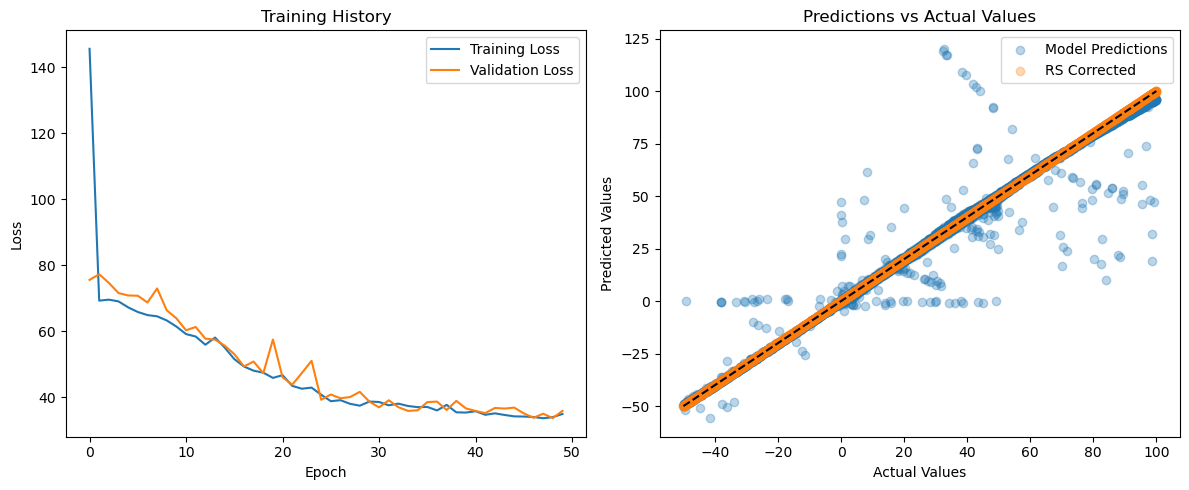

In [8]:
%matplotlib inline

plt.figure(figsize=(12, 5))

# Training history
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Predictions vs Actual
plt.subplot(1, 2, 2)
plt.scatter(y_test.values.flatten(), y_pred.flatten(), alpha=0.3, label='Model Predictions')
plt.scatter(y_test.values.flatten(), 
           rs_pred[['sensor_reading_rs_corrected', 'temperature_rs_corrected']].values.flatten(), 
           alpha=0.3, label='RS Corrected')
plt.plot([-50, 100], [-50, 100], 'k--')
plt.title('Predictions vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()

plt.tight_layout()
plt.show()

In [9]:
corrected_df = original_df.copy()
corrected_df['sensor_reading_model_corrected'] = model.predict(X)[:, 0]
corrected_df['temperature_model_corrected'] = model.predict(X)[:, 1]

engine = create_engine('sqlite:///satellite_data.db', echo=False)
corrected_df.to_sql('corrected_satellite_data', con=engine, if_exists='replace', index=False)

print("✅ Data saved to database successfully!")
print("Database path: satellite_data.db")

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
✅ Data saved to database successfully!
Database path: satellite_data.db
